# Classify names with character n-grams

In [1]:
from argparse import Namespace

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook

%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (14, 6)

c:\users\user2\anaconda3\envs\tensorflow\lib\importlib\_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [10]:
sns.__version__

'0.9.0'

## Overview of Data/Task
- Data compiled by [Sean Robertson](https://github.com/spro)
- Predict nationality from names.
- Data consist of 20074 names, 18 categories. 
- Russian names are dominant (skewing labels)
  - We downsample russian names to minimize the skew. Checkout the RNN tutorial for a different approach to handle label bias.

```
    2750 names_test.csv
   10994 names_train.csv
```

### Args for this example

In [7]:
args = Namespace(
    surname_csv="./data/surnames.csv",
    model_filename="names_mlp_model.pth",
    cuda=False,
    num_epochs=100
)


# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

print("Using CUDA: {}".format(args.cuda))

args.device = torch.device("cuda" if args.cuda else "cpu")
args.device

Using CUDA: False


device(type='cpu')

## Load names

In [8]:
name_data = pd.read_csv(args.surname_csv)

## Class Breakdown

c:\users\user2\anaconda3\envs\tensorflow\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


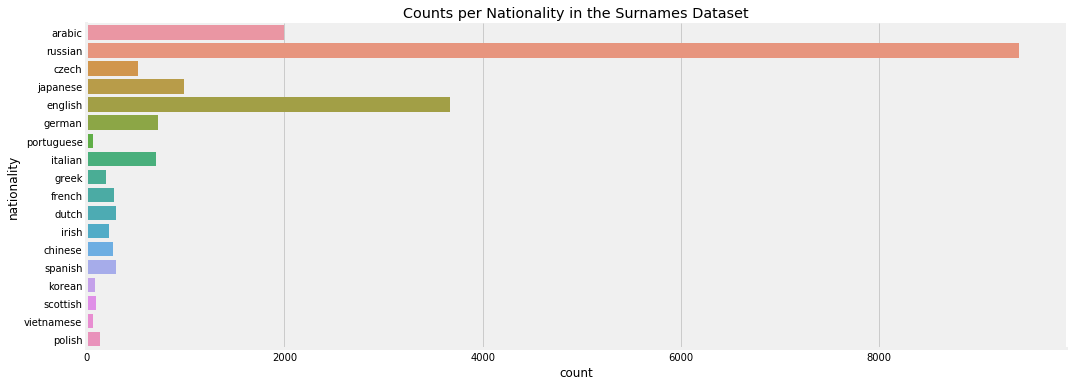

In [11]:
sns.factorplot(data=name_data, y='nationality', 
               kind='count', height=5, aspect=3);
plt.title("Counts per Nationality in the Surnames Dataset");

In [55]:
def fix_imbalance(df):
    median = df.groupby('nationality').agg('count').split.median()
    for nationality in df.nationality.unique():
        
        df_main = df[df.nationality != nationality]
        df_sub = df[df.nationality == nationality].reset_index(drop=True)
        if len(df_sub) > median:
            size = min(len(df_sub), int(median+0.05*len(df_sub)))
            indices = np.random.choice(np.arange(len(df_sub)), 
                                       size=size, 
                                       replace=False)
            df_sub = df_sub.iloc[indices]
        df = pd.concat([df_main, df_sub]).reset_index(drop=True)
    return df

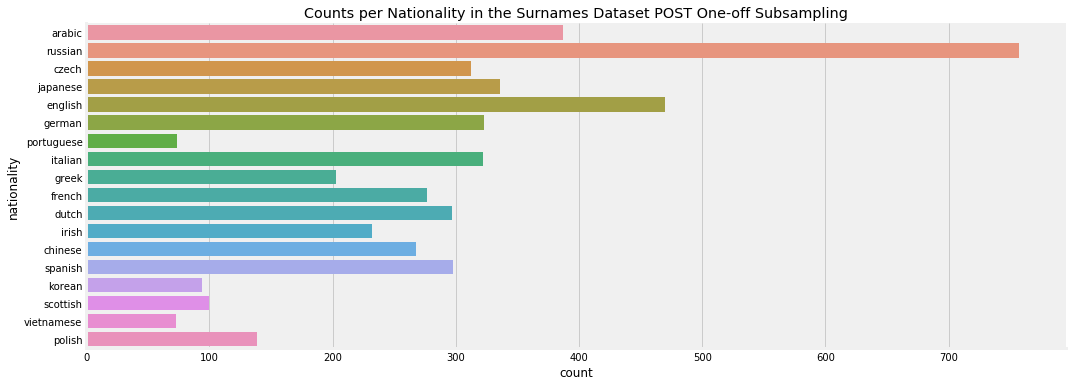

In [6]:
name_data = fix_imbalance(name_data)
sns.catplot(data=name_data, y='nationality', 
               kind='count', height=5, aspect=3);
plt.title("Counts per Nationality in the Surnames Dataset POST One-off Subsampling");

# Feature Engineering

## 1. Lowercase

In [20]:
name_data['features'] = name_data['surname'].apply(lambda x: x.lower())
name_data.head()
name_data

,split,surname,nationality,features
0,train,Hadad,arabic,hadad
1,train,Prikazchikov,russian,prikazchikov
2,train,Bajov,russian,bajov
3,train,Awduewsky,russian,awduewsky
4,train,Jablochkov,russian,jablochkov
5,train,Panek,czech,panek
6,train,Imnadze,russian,imnadze
7,train,Kinashita,japanese,kinashita
8,train,Mahortov,russian,mahortov
9,train,Kenyon,english,kenyon


## 2. Add begin and end tokens


In [21]:
def add_begin_end_tokens(name):
    # return "^{}$".format(name)
    begin_token_marker = "^"
    end_token_marker = '$'
    return "".join((begin_token_marker, name, end_token_marker))

In [22]:
name_data['features'] = name_data['features'].apply(add_begin_end_tokens)
name_data.head()

,split,surname,nationality,features
0,train,Hadad,arabic,^hadad$
1,train,Prikazchikov,russian,^prikazchikov$
2,train,Bajov,russian,^bajov$
3,train,Awduewsky,russian,^awduewsky$
4,train,Jablochkov,russian,^jablochkov$


## 3. Extract Character N-grams

In [23]:
def extract_n_grams(tokens, n):
    '''
    param tokens: tokenized text
    return: list of n grams
    '''
    return [tokens[i:i + n] for i in range(len(tokens) - n + 1)]

In [24]:
# use trigrams
name_data['features'] = name_data['features'].apply(lambda x: extract_n_grams(x, 3))
name_data.head()

,split,surname,nationality,features
0,train,Hadad,arabic,"[^ha, had, ada, dad, ad$]"
1,train,Prikazchikov,russian,"[^pr, pri, rik, ika, kaz, azc, zch, chi, hik, ..."
2,train,Bajov,russian,"[^ba, baj, ajo, jov, ov$]"
3,train,Awduewsky,russian,"[^aw, awd, wdu, due, uew, ews, wsk, sky, ky$]"
4,train,Jablochkov,russian,"[^ja, jab, abl, blo, loc, och, chk, hko, kov, ..."


## 4. Build vocabulary

In [25]:
vocabulary  = set()
for name in name_data['features'].values:
    [vocabulary.add(ngram) for ngram in name]        

In [26]:
maxlen = max(name_data['features'].apply(len))
maxlen

20

## 5. Map n-grams to indices

In [32]:
ngram_to_index = {ngram:i for i, ngram in enumerate(vocabulary, 1)}
ngram_to_index

{'asl': 1,
 'mog': 2897,
 'uph': 2319,
 'höf': 2,
 'ece': 3481,
 'tbe': 3,
 'ivk': 4,
 'my$': 4740,
 'sgh': 3482,
 'byt': 5,
 'ojo': 6,
 'cut': 3484,
 'uja': 7,
 'ilb': 3485,
 'drí': 3486,
 'koz': 3487,
 'vu$': 8,
 'utl': 9,
 'myu': 10,
 'rug': 5609,
 'omj': 3491,
 'ckw': 3492,
 'tzn': 13,
 '^is': 12,
 'doe': 3494,
 'vai': 14,
 'set': 4050,
 'otz': 3495,
 'ówk': 5583,
 'aux': 3496,
 'lx$': 2322,
 'rka': 3497,
 'pyg': 596,
 'ypo': 1500,
 'bdi': 3498,
 'atz': 6541,
 'uzs': 3499,
 'szt': 15,
 'del': 16,
 'eay': 17,
 'nnd': 18,
 "v'y": 19,
 'vyg': 3500,
 'pa$': 20,
 '^bä': 23,
 'vyr': 22,
 'fum': 3503,
 'emp': 24,
 'vro': 3504,
 'far': 25,
 'a c': 2902,
 '-la': 3505,
 'rnt': 3506,
 'not': 3507,
 'aeb': 26,
 'dwa': 3508,
 'khn': 3509,
 'khy': 27,
 'lmy': 28,
 'zba': 3510,
 'bba': 29,
 'nam': 3565,
 'làc': 3511,
 'tzk': 3512,
 'mai': 3513,
 'jog': 30,
 'uks': 34,
 'atd': 32,
 'efa': 3516,
 'chl': 35,
 'own': 36,
 'mph': 37,
 'ipk': 3519,
 '^we': 6336,
 'eap': 38,
 'vgu': 3521,
 'bog': 39,
 '

In [28]:
def n_grams_to_indices(n_grams):
    unknown_index = len(ngram_to_index) + 1
    return [ngram_to_index.get(ngram, unknown_index) for ngram in n_grams]  

In [29]:
n_grams_to_indices(['^ha', 'had', 'ada', 'dad', 'ad$'])

[5470, 4450, 6832, 1401, 3269]

## 6. Pad indices

In [42]:
def pad_indices(indices, maxlen=20):
    padded = np.zeros(maxlen, dtype=np.int64)
#     print(padded)
    for i, index in enumerate(indices):
        padded[i] = index
#         print(padded)
    return padded 

In [43]:
test_name = n_grams_to_indices(['^ha', 'had', 'ada', 'dad', 'ad$'])
pad_indices(test_name, 20)

array([5470, 4450, 6832, 1401, 3269,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int64)

## 7. Encode class labels as numbers

In [44]:
label_to_number = {y: i for i, y in enumerate(sorted(set(name_data['nationality'])))}
number_to_label = {i: y for i, y in enumerate(sorted(set(name_data['nationality'])))}

In [45]:
label_to_number

{'arabic': 0,
 'chinese': 1,
 'czech': 2,
 'dutch': 3,
 'english': 4,
 'french': 5,
 'german': 6,
 'greek': 7,
 'irish': 8,
 'italian': 9,
 'japanese': 10,
 'korean': 11,
 'polish': 12,
 'portuguese': 13,
 'russian': 14,
 'scottish': 15,
 'spanish': 16,
 'vietnamese': 17}

In [46]:
number_to_label

{0: 'arabic',
 1: 'chinese',
 2: 'czech',
 3: 'dutch',
 4: 'english',
 5: 'french',
 6: 'german',
 7: 'greek',
 8: 'irish',
 9: 'italian',
 10: 'japanese',
 11: 'korean',
 12: 'polish',
 13: 'portuguese',
 14: 'russian',
 15: 'scottish',
 16: 'spanish',
 17: 'vietnamese'}

## 8. Consolidate data preperation pipeline

In [47]:
def extract_name_features(name, n_grams=3):
    """
    Applies feature extraction pipeline to name
    """
    features = name.lower()
    features = add_begin_end_tokens(features)
    features = extract_n_grams(features, n_grams)
    features = n_grams_to_indices(features)
    features = pad_indices(features)
    features = torch.from_numpy(features).long()
    return features

In [49]:
extract_name_features('JoJO')

tensor([6247, 6915,    6, 6915, 6915, 6915, 6915, 6915,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

## Create PyTorch Dataset

In [56]:
class VectorizedSurnames(Dataset):
    """Name Classification dataset"""

    def __init__(self, data):
        '''
        Args:
            data (pandas.DataFrame)
        '''
        self.data = data
        self.x_surnames = self.data['surname'].apply(lambda x: extract_name_features(x, 3))
        self.y_nationalities = self.data['nationality'].apply(lambda x: label_to_number[x])

    @classmethod
    def from_file(cls, filename, split='train', apply_fix=True):
        df = pd.read_csv(filename).dropna()
        df = df[df.split == split]
        if apply_fix:
            df = fix_imbalance(df)
        return cls(df)
    
    def __len__(self):
        return len(self.x_surnames)

    def __getitem__(self, index):
        return {'x_surnames': self.x_surnames.iloc[index],
                'y_nationalities': self.y_nationalities.iloc[index]}

In [61]:
name_dataset = VectorizedSurnames.from_file(args.surname_csv, split='train', apply_fix=True)

In [62]:
# index first into the __getitem__ above and then into the resulting dictionary
name_dataset[0]['x_surnames'].type()

'torch.LongTensor'

In [66]:
dataloader = DataLoader(name_dataset, batch_size=32, shuffle=True)

## Define MLP

In [67]:
class MLP(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_size, maxlen, dropout_p=0.5):
        super(MLP, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.fc1 = nn.Linear(embedding_dim * maxlen, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_size)
        self._dropout_p = dropout_p

    def forward(self, x, apply_softmax=False):
        x = self.embeddings(x).view(-1, (embedding_dim * maxlen))
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self._dropout_p)
        x = self.fc2(x)
        if apply_softmax:
            x = F.softmax(x, dim=1)
        return x

In [68]:
vocab_size = len(vocabulary) + 2 # one for unknown index
embedding_dim = 100 # hidden dim.
hidden_dim = 200
output_size = len(label_to_number) # number of classes
maxlen = 20

classifier = MLP(vocab_size, embedding_dim, hidden_dim, output_size, maxlen)

## Train

In [69]:
def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [70]:
classifier = classifier.to(args.device)

optimizer = optim.Adam(classifier.parameters())
criterion = nn.CrossEntropyLoss()

loss_history = []
accuracy_history = []

epoch_bar = tqdm_notebook(desc='epochs', total=args.num_epochs)

try:
    for _ in range(args.num_epochs):
        per_epoch_losses = []
        per_epoch_accuracy = []
        for batch in dataloader:
            # Step 1: clear the gradients 
            optimizer.zero_grad()

            # Step 2: apply the model to the data
            x_surnames = batch['x_surnames'].to(args.device)
            y_nationalities = batch['y_nationalities'].to(args.device)

            y_prediction = classifier(x_surnames)

            # Step 3: compute the loss and propagate the gradients
            
            loss = criterion(y_prediction, y_nationalities)
            loss.backward()

            # Step 4; have optimizer update the model weights
            optimizer.step()
            
            # bonus steps:  bookkeeping
            
            per_epoch_losses.append(loss.item())
            
            accuracy = compute_accuracy(y_prediction, y_nationalities)
            per_epoch_accuracy.append(accuracy)
            


        loss_history.append(np.mean(per_epoch_losses))
        accuracy_history.append(np.mean(per_epoch_accuracy))
        epoch_bar.set_postfix(loss=loss_history[-1], accuracy=accuracy_history[-1])
        epoch_bar.update()
except KeyboardInterrupt:
    print("...")

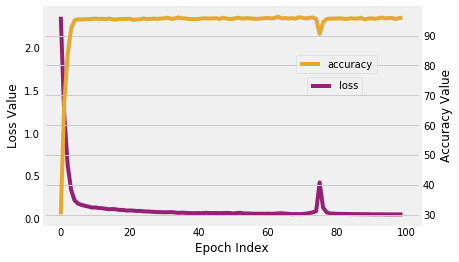

In [71]:
_, ax = plt.subplots(1, 1)
ax.plot(loss_history, color='#942174', label='loss')
plt.legend(bbox_to_anchor=(0.86, 0.7))
ax.grid(False)
ax.set_xlabel("Epoch Index")
ax.set_ylabel("Loss Value")
ax2 = plt.twinx()
ax2.set_ylabel("Accuracy Value")
ax2.plot(accuracy_history, color='#e5a930', label='accuracy')
plt.legend(bbox_to_anchor=(0.9, 0.8))

## save model

In [72]:
torch.save(classifier.state_dict(), args.model_filename)

## load model

In [38]:
classifier.load_state_dict(torch.load(args.model_filename))

## Evaluate on test set

In [73]:
# args.device = "cuda"

In [74]:
from sklearn.metrics import confusion_matrix, accuracy_score

name_dataset_test = VectorizedSurnames.from_file(args.surname_csv, split='test')
dataloader_test = DataLoader(name_dataset_test, batch_size=16, shuffle=True, num_workers=0)

classifier = classifier.to(args.device)

classifier.eval()

ground_truth = []
predictions = []
for batch in dataloader:
    x_surnames = batch['x_surnames'].to(args.device)
    y_nationalities = batch['y_nationalities'].to(args.device)

    
    outputs = classifier(x_surnames)
    
    y_pred_probabilities, y_pred_indices = torch.max(outputs, dim=1)
    
    ground_truth.append(y_nationalities.detach().cpu().numpy())
    predictions.append(y_pred_indices.detach().cpu().squeeze().numpy())
    
ground_truth = np.concatenate(ground_truth)
predictions = np.concatenate(predictions)

print(accuracy_score(ground_truth, predictions)) 

0.96875


Text(0.5,1,'Counts per Nationality in the Surnames Test Set')

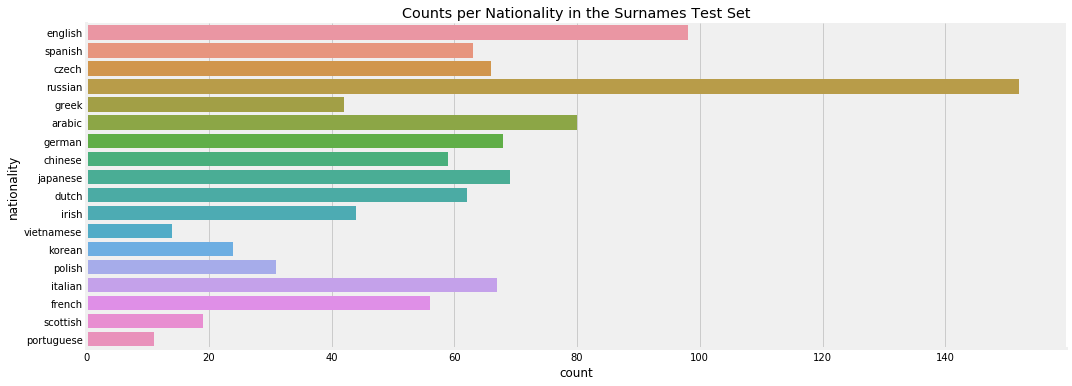

In [76]:
sns.catplot(data=name_dataset_test.data, y='nationality', 
               kind='count', height=5, aspect=3);
plt.title("Counts per Nationality in the Surnames Test Set")

In [77]:
labels = name_dataset_test.data.nationality.values

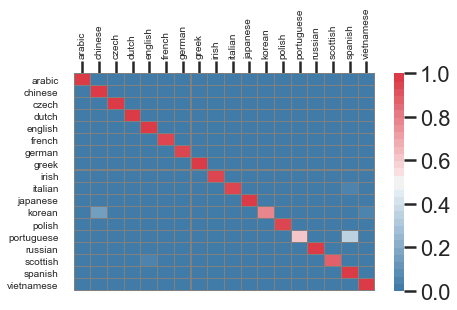

In [78]:
sns.set_style('white')
sns.set_context('poster')
labels = [number_to_label[i] for i in range(len(number_to_label))]
cm = confusion_matrix(ground_truth, predictions).astype(np.float32)
cm /= cm.sum(axis=1, keepdims=True)
g = sns.heatmap(cm, 
                cmap=sns.diverging_palette(240, 10, n=30), 
                center=0.5,
                linewidths=0.01, 
                linecolor='gray');
g.xaxis.tick_top()
g.set_xticks([0.5 + i for i in range(len(labels))])
g.set_yticks([0.5 + i for i in range(len(labels))])
g.set_xticklabels(labels, rotation=90, size=10);
g.set_yticklabels(labels, rotation=0, size=10);


## Exercise: run your name through the model

In [84]:
name = extract_name_features('Jo')
name = name.view(1,-1) # reshape because model expects a batch

prediction = classifier(name.to(args.device), apply_softmax=True)
top_pred, index = torch.max(prediction, dim=1)
number_to_label[index[0].item()]

'japanese'